# Comparative Analysis of Video Compression Standards: MPEG-4, H.264, and H.265

**Author:** Yousef Abdulziz AbuAmna (120221377)  
**Institution:** Islamic University of Gaza — Faculty of Information Technology  
**Date:** June 2026

---

## Overview
This notebook implements the full experimental pipeline for comparing MPEG-4, H.264, and H.265 video compression standards:

1. **Setup & Dependencies** — Install all required tools and libraries
2. **Sample Video Download** — Obtain test video sequences
3. **Video Encoding** — Encode using MPEG-4, H.264, H.265 at multiple bitrates
4. **Feature Extraction** — Bitrate, file size, PSNR, SSIM, encoding time, motion complexity
5. **Machine Learning Analysis** — Regression models for compression prediction
6. **Comparative Evaluation** — Visualizations and statistical comparisons
7. **Results & Discussion**

---
## 1. Setup & Dependencies
Install all required Python packages and FFmpeg (the core tool for video encoding).

In [1]:
# ============================================================
# 1a. Install Python packages
# ============================================================
!pip install numpy pandas matplotlib seaborn scikit-learn scikit-image opencv-python-headless tqdm requests

  Using cached numpy-2.4.2-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached pandas-3.0.1-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached tqdm-4.67.3-py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpool

In [2]:
# ============================================================
# 1b. Install FFmpeg  (Windows)
# This downloads a static FFmpeg build and adds it to PATH
# ============================================================
import os, zipfile, urllib.request, shutil, subprocess, sys

FFMPEG_DIR = os.path.join(os.getcwd(), 'ffmpeg')
FFMPEG_EXE = os.path.join(FFMPEG_DIR, 'ffmpeg.exe')

def check_ffmpeg():
    """Return path to ffmpeg if available."""
    if os.path.isfile(FFMPEG_EXE):
        return FFMPEG_EXE
    if shutil.which('ffmpeg'):
        return shutil.which('ffmpeg')
    return None

if check_ffmpeg() is None:
    print('FFmpeg not found. Downloading static build...')
    url = 'https://www.gyan.dev/ffmpeg/builds/ffmpeg-release-essentials.zip'
    zip_path = os.path.join(os.getcwd(), 'ffmpeg_download.zip')
    print(f'Downloading from {url} ...')
    urllib.request.urlretrieve(url, zip_path)
    print('Extracting...')
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(os.getcwd())
    os.remove(zip_path)
    # Find the extracted ffmpeg.exe and move to our ffmpeg/ folder
    os.makedirs(FFMPEG_DIR, exist_ok=True)
    for root, dirs, files in os.walk(os.getcwd()):
        for f in files:
            if f == 'ffmpeg.exe' and 'ffmpeg' in root:
                src = os.path.join(root, f)
                if src != FFMPEG_EXE:
                    shutil.copy2(src, FFMPEG_EXE)
                    # Also copy ffprobe
                    probe_src = os.path.join(root, 'ffprobe.exe')
                    if os.path.isfile(probe_src):
                        shutil.copy2(probe_src, os.path.join(FFMPEG_DIR, 'ffprobe.exe'))
                    break
    # Clean up extracted folder
    for item in os.listdir(os.getcwd()):
        full = os.path.join(os.getcwd(), item)
        if os.path.isdir(full) and item.startswith('ffmpeg-') and item != 'ffmpeg':
            shutil.rmtree(full, ignore_errors=True)

FFMPEG = check_ffmpeg()
FFPROBE = os.path.join(os.path.dirname(FFMPEG), 'ffprobe.exe') if FFMPEG else None
if not FFPROBE or not os.path.isfile(FFPROBE):
    FFPROBE = shutil.which('ffprobe')

print(f'FFmpeg  : {FFMPEG}')
print(f'FFprobe : {FFPROBE}')
result = subprocess.run([FFMPEG, '-version'], capture_output=True, text=True)
print(result.stdout.split('\n')[0])

FFmpeg not found. Downloading static build...
Extracting...
FFmpeg  : c:\Users\Public\Comparative_Analysis_Video\ffmpeg\ffmpeg.exe
FFprobe : c:\Users\Public\Comparative_Analysis_Video\ffmpeg\ffprobe.exe
ffmpeg version 8.0.1-essentials_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers


In [3]:
# ============================================================
# 1c. Import libraries
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import time
import subprocess
import os
import warnings
from pathlib import Path
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Working directories
BASE_DIR   = Path(os.getcwd())
VIDEO_DIR  = BASE_DIR / 'videos'
OUTPUT_DIR = BASE_DIR / 'encoded'
RESULTS_DIR = BASE_DIR / 'results'
for d in [VIDEO_DIR, OUTPUT_DIR, RESULTS_DIR]:
    d.mkdir(exist_ok=True)

print('All libraries loaded successfully.')
print(f'Base directory : {BASE_DIR}')
print(f'Video directory: {VIDEO_DIR}')
print(f'Output directory: {OUTPUT_DIR}')

All libraries loaded successfully.
Base directory : c:\Users\Public\Comparative_Analysis_Video
Video directory: c:\Users\Public\Comparative_Analysis_Video\videos
Output directory: c:\Users\Public\Comparative_Analysis_Video\encoded


---
## 2. Download Sample Test Videos
We download standard test sequences commonly used in video compression research. These cover diverse content types (high motion, low motion, varying textures).

In [4]:
# ============================================================
# 2. Download sample test videos
# Using publicly available short clips from standard test sources
# ============================================================
import requests

# Public domain / CC-licensed short test videos
# These are small clips suitable for compression experiments
SAMPLE_VIDEOS = {
    'BigBuckBunny_360p': 'https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/360/Big_Buck_Bunny_360_10s_1MB.mp4',
    'BigBuckBunny_720p': 'https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/720/Big_Buck_Bunny_720_10s_2MB.mp4',
    'Jellyfish_360p':    'https://test-videos.co.uk/vids/jellyfish/mp4/h264/360/Jellyfish_360_10s_1MB.mp4',
    'Jellyfish_720p':    'https://test-videos.co.uk/vids/jellyfish/mp4/h264/720/Jellyfish_720_10s_2MB.mp4',
    'Sintel_360p':       'https://test-videos.co.uk/vids/sintel/mp4/h264/360/Sintel_360_10s_1MB.mp4',
    'Sintel_720p':       'https://test-videos.co.uk/vids/sintel/mp4/h264/720/Sintel_720_10s_2MB.mp4',
}

downloaded_videos = []

for name, url in SAMPLE_VIDEOS.items():
    filepath = VIDEO_DIR / f'{name}.mp4'
    if filepath.exists():
        print(f'[SKIP] {name} already downloaded.')
        downloaded_videos.append(filepath)
        continue
    print(f'[DOWNLOAD] {name} ...')
    try:
        resp = requests.get(url, timeout=60)
        resp.raise_for_status()
        filepath.write_bytes(resp.content)
        downloaded_videos.append(filepath)
        print(f'  -> Saved ({len(resp.content)/1024:.0f} KB)')
    except Exception as e:
        print(f'  -> FAILED: {e}')

print(f'\nTotal videos ready: {len(downloaded_videos)}')
for v in downloaded_videos:
    print(f'  {v.name}  ({v.stat().st_size/1024:.0f} KB)')

[DOWNLOAD] BigBuckBunny_360p ...
  -> Saved (968 KB)
[DOWNLOAD] BigBuckBunny_720p ...
  -> Saved (1932 KB)
[DOWNLOAD] Jellyfish_360p ...
  -> Saved (1023 KB)
[DOWNLOAD] Jellyfish_720p ...
  -> Saved (2048 KB)
[DOWNLOAD] Sintel_360p ...
  -> Saved (1023 KB)
[DOWNLOAD] Sintel_720p ...
  -> Saved (2045 KB)

Total videos ready: 6
  BigBuckBunny_360p.mp4  (968 KB)
  BigBuckBunny_720p.mp4  (1932 KB)
  Jellyfish_360p.mp4  (1023 KB)
  Jellyfish_720p.mp4  (2048 KB)
  Sintel_360p.mp4  (1023 KB)
  Sintel_720p.mp4  (2045 KB)


In [5]:
# ============================================================
# 2b. (Optional) Add your own videos
# Place .mp4 files in the 'videos/' folder and run this cell
# ============================================================
all_videos = sorted(VIDEO_DIR.glob('*.mp4'))
print(f'All available videos ({len(all_videos)}):')
for v in all_videos:
    print(f'  {v.name}  ({v.stat().st_size/1024:.0f} KB)')

All available videos (6):
  BigBuckBunny_360p.mp4  (968 KB)
  BigBuckBunny_720p.mp4  (1932 KB)
  Jellyfish_360p.mp4  (1023 KB)
  Jellyfish_720p.mp4  (2048 KB)
  Sintel_360p.mp4  (1023 KB)
  Sintel_720p.mp4  (2045 KB)


---
## 3. Video Encoding Experiments
Encode each source video using three codecs at multiple bitrates:
- **MPEG-4 (Part 2)** — codec: `mpeg4`
- **H.264 / AVC** — codec: `libx264`
- **H.265 / HEVC** — codec: `libx265`

Bitrate settings: **500k, 1M, 2M, 4M, 8M**

In [6]:
# ============================================================
# 3a. Helper functions for encoding & metrics
# ============================================================

CODECS = {
    'MPEG4':  {'encoder': 'mpeg4',   'ext': 'mp4', 'extra': []},
    'H264':   {'encoder': 'libx264', 'ext': 'mp4', 'extra': ['-preset', 'medium']},
    'H265':   {'encoder': 'libx265', 'ext': 'mp4', 'extra': ['-preset', 'medium', '-tag:v', 'hvc1']},
}

BITRATES = ['500k', '1M', '2M', '4M', '8M']

def bitrate_to_kbps(br_str):
    """Convert bitrate string like '500k' or '2M' to numeric kbps."""
    br_str = br_str.strip().upper()
    if br_str.endswith('K'):
        return int(br_str[:-1])
    elif br_str.endswith('M'):
        return int(float(br_str[:-1]) * 1000)
    return int(br_str) // 1000

def get_video_info(video_path):
    """Get video metadata using ffprobe."""
    cmd = [
        FFPROBE, '-v', 'quiet', '-print_format', 'json',
        '-show_format', '-show_streams', str(video_path)
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    info = json.loads(result.stdout)
    video_stream = next((s for s in info['streams'] if s['codec_type'] == 'video'), {})
    return {
        'width': int(video_stream.get('width', 0)),
        'height': int(video_stream.get('height', 0)),
        'fps': eval(video_stream.get('r_frame_rate', '0/1')),
        'duration': float(info['format'].get('duration', 0)),
        'bitrate_kbps': int(info['format'].get('bit_rate', 0)) / 1000,
        'nb_frames': int(video_stream.get('nb_frames', 0)),
        'codec': video_stream.get('codec_name', 'unknown'),
    }

def encode_video(input_path, output_path, codec_name, bitrate):
    """Encode a video with given codec and bitrate. Returns encoding time."""
    codec = CODECS[codec_name]
    cmd = [
        FFMPEG, '-y', '-i', str(input_path),
        '-c:v', codec['encoder'],
        '-b:v', bitrate,
        *codec['extra'],
        '-an',            # no audio (focus on video compression)
        '-threads', '4',
        str(output_path)
    ]
    start_time = time.time()
    result = subprocess.run(cmd, capture_output=True, text=True)
    encoding_time = time.time() - start_time
    if result.returncode != 0:
        print(f'  [ERROR] {codec_name} @ {bitrate}: {result.stderr[-200:]}')
    return encoding_time

def compute_quality_metrics(original_path, encoded_path, max_frames=50):
    """Compute PSNR and SSIM between original and encoded video (sampled frames)."""
    cap_orig = cv2.VideoCapture(str(original_path))
    cap_enc  = cv2.VideoCapture(str(encoded_path))
    
    psnr_values = []
    ssim_values = []
    frame_count = 0
    
    total_frames = int(cap_orig.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // max_frames)
    
    while True:
        ret1, frame1 = cap_orig.read()
        ret2, frame2 = cap_enc.read()
        if not ret1 or not ret2:
            break
        frame_count += 1
        if frame_count % step != 0:
            continue
        # Resize encoded frame to match original if needed
        if frame1.shape != frame2.shape:
            frame2 = cv2.resize(frame2, (frame1.shape[1], frame1.shape[0]))
        # Convert to grayscale for SSIM
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        psnr_val = psnr(gray1, gray2)
        ssim_val = ssim(gray1, gray2)
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
    
    cap_orig.release()
    cap_enc.release()
    
    return {
        'psnr_mean': np.mean(psnr_values) if psnr_values else 0,
        'psnr_std':  np.std(psnr_values)  if psnr_values else 0,
        'ssim_mean': np.mean(ssim_values) if ssim_values else 0,
        'ssim_std':  np.std(ssim_values)  if ssim_values else 0,
        'frames_compared': len(psnr_values)
    }

def compute_motion_complexity(video_path, max_frames=100):
    """Estimate motion complexity via mean optical flow magnitude."""
    cap = cv2.VideoCapture(str(video_path))
    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        return 0.0
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    flow_magnitudes = []
    count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // max_frames)
    
    while count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        count += 1
        if count % step != 0:
            prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
        flow_magnitudes.append(np.mean(magnitude))
        prev_gray = gray
    
    cap.release()
    return np.mean(flow_magnitudes) if flow_magnitudes else 0.0

print('Helper functions defined.')

Helper functions defined.


In [7]:
# ============================================================
# 3b. Run encoding experiments
# ============================================================
all_videos = sorted(VIDEO_DIR.glob('*.mp4'))
results = []

print(f'Encoding {len(all_videos)} videos × {len(CODECS)} codecs × {len(BITRATES)} bitrates')
print(f'= {len(all_videos) * len(CODECS) * len(BITRATES)} total encodes\n')

for video_path in all_videos:
    video_name = video_path.stem
    print(f'\n{"="*60}')
    print(f'Video: {video_name}')
    print(f'{"="*60}')
    
    # Get source video info
    src_info = get_video_info(video_path)
    motion_complexity = compute_motion_complexity(video_path)
    original_size_kb = video_path.stat().st_size / 1024
    
    print(f'  Resolution: {src_info["width"]}x{src_info["height"]}, '
          f'FPS: {src_info["fps"]:.1f}, Duration: {src_info["duration"]:.1f}s, '
          f'Motion: {motion_complexity:.2f}')
    
    for codec_name in CODECS:
        for bitrate in BITRATES:
            out_name = f'{video_name}_{codec_name}_{bitrate}.mp4'
            out_path = OUTPUT_DIR / out_name
            
            # Encode
            enc_time = encode_video(video_path, out_path, codec_name, bitrate)
            
            if not out_path.exists():
                print(f'  [SKIP] {codec_name} @ {bitrate} — encoding failed')
                continue
            
            # Get encoded video info
            enc_info = get_video_info(out_path)
            encoded_size_kb = out_path.stat().st_size / 1024
            
            # Compute quality metrics
            quality = compute_quality_metrics(video_path, out_path)
            
            # Compression ratio
            compression_ratio = original_size_kb / encoded_size_kb if encoded_size_kb > 0 else 0
            bitrate_savings_pct = (1 - encoded_size_kb / original_size_kb) * 100
            
            row = {
                'video': video_name,
                'codec': codec_name,
                'target_bitrate': bitrate,
                'target_bitrate_kbps': bitrate_to_kbps(bitrate),
                'actual_bitrate_kbps': enc_info['bitrate_kbps'],
                'width': src_info['width'],
                'height': src_info['height'],
                'resolution': f"{src_info['width']}x{src_info['height']}",
                'fps': src_info['fps'],
                'duration_s': src_info['duration'],
                'original_size_kb': round(original_size_kb, 2),
                'encoded_size_kb': round(encoded_size_kb, 2),
                'compression_ratio': round(compression_ratio, 3),
                'bitrate_savings_pct': round(bitrate_savings_pct, 2),
                'encoding_time_s': round(enc_time, 3),
                'psnr_mean': round(quality['psnr_mean'], 3),
                'psnr_std': round(quality['psnr_std'], 3),
                'ssim_mean': round(quality['ssim_mean'], 5),
                'ssim_std': round(quality['ssim_std'], 5),
                'motion_complexity': round(motion_complexity, 4),
                'frames_compared': quality['frames_compared'],
            }
            results.append(row)
            print(f'  {codec_name:5s} @ {bitrate:4s} -> '
                  f'Size: {encoded_size_kb:7.0f} KB | '
                  f'PSNR: {quality["psnr_mean"]:5.1f} dB | '
                  f'SSIM: {quality["ssim_mean"]:.4f} | '
                  f'Time: {enc_time:.2f}s')

print(f'\n\nDone! {len(results)} encoding experiments completed.')

Encoding 6 videos × 3 codecs × 5 bitrates
= 90 total encodes


Video: BigBuckBunny_360p
  Resolution: 640x360, FPS: 30.0, Duration: 10.0s, Motion: 0.27
  MPEG4 @ 500k -> Size:     873 KB | PSNR:  30.2 dB | SSIM: 0.8182 | Time: 0.22s
  MPEG4 @ 1M   -> Size:    1462 KB | PSNR:  32.0 dB | SSIM: 0.8782 | Time: 0.23s
  MPEG4 @ 2M   -> Size:    2649 KB | PSNR:  34.3 dB | SSIM: 0.9269 | Time: 0.23s
  MPEG4 @ 4M   -> Size:    5038 KB | PSNR:  37.6 dB | SSIM: 0.9637 | Time: 0.25s
  MPEG4 @ 8M   -> Size:    7662 KB | PSNR:  40.0 dB | SSIM: 0.9787 | Time: 0.27s
  H264  @ 500k -> Size:     601 KB | PSNR:  35.0 dB | SSIM: 0.9409 | Time: 1.15s
  H264  @ 1M   -> Size:    1184 KB | PSNR:  38.5 dB | SSIM: 0.9743 | Time: 1.33s
  H264  @ 2M   -> Size:    2386 KB | PSNR:  42.0 dB | SSIM: 0.9881 | Time: 1.60s
  H264  @ 4M   -> Size:    4815 KB | PSNR:  45.2 dB | SSIM: 0.9941 | Time: 2.00s
  H264  @ 8M   -> Size:    9714 KB | PSNR:  49.1 dB | SSIM: 0.9974 | Time: 2.66s
  H265  @ 500k -> Size:     591 KB | P

In [8]:
# ============================================================
# 3c. Save results to CSV
# ============================================================
df = pd.DataFrame(results)
csv_path = RESULTS_DIR / 'encoding_results.csv'
df.to_csv(csv_path, index=False)
print(f'Results saved to {csv_path}')
print(f'Shape: {df.shape}')
df.head(10)

Results saved to c:\Users\Public\Comparative_Analysis_Video\results\encoding_results.csv
Shape: (90, 21)


,video,codec,target_bitrate,target_bitrate_kbps,actual_bitrate_kbps,width,height,resolution,fps,duration_s,...,encoded_size_kb,compression_ratio,bitrate_savings_pct,encoding_time_s,psnr_mean,psnr_std,ssim_mean,ssim_std,motion_complexity,frames_compared
0,BigBuckBunny_360p,MPEG4,500k,500,715.199,640,360,640x360,30.0,10.0,...,873.05,1.109,9.79,0.223,30.231,1.306,0.81821,0.03945,0.2693,50
1,BigBuckBunny_360p,MPEG4,1M,1000,1197.335,640,360,640x360,30.0,10.0,...,1461.59,0.662,-51.02,0.235,32.017,1.298,0.87822,0.02546,0.2693,50
2,BigBuckBunny_360p,MPEG4,2M,2000,2170.403,640,360,640x360,30.0,10.0,...,2649.42,0.365,-173.76,0.234,34.320,1.297,0.92690,0.01475,0.2693,50
3,BigBuckBunny_360p,MPEG4,4M,4000,4126.784,640,360,640x360,30.0,10.0,...,5037.58,0.192,-420.52,0.254,37.561,0.893,0.96369,0.00555,0.2693,50
4,BigBuckBunny_360p,MPEG4,8M,8000,6276.968,640,360,640x360,30.0,10.0,...,7662.31,0.126,-691.73,0.266,39.968,0.100,0.97868,0.00035,0.2693,50
5,BigBuckBunny_360p,H264,500k,500,492.304,640,360,640x360,30.0,10.0,...,600.96,1.610,37.90,1.153,35.027,1.326,0.94088,0.01950,0.2693,50
6,BigBuckBunny_360p,H264,1M,1000,969.572,640,360,640x360,30.0,10.0,...,1183.56,0.818,-22.30,1.335,38.546,1.218,0.97429,0.00636,0.2693,50
7,BigBuckBunny_360p,H264,2M,2000,1954.347,640,360,640x360,30.0,10.0,...,2385.68,0.406,-146.51,1.598,41.977,1.047,0.98810,0.00228,0.2693,50
8,BigBuckBunny_360p,H264,4M,4000,3944.747,640,360,640x360,30.0,10.0,...,4815.37,0.201,-397.56,1.996,45.218,0.930,0.99407,0.00107,0.2693,50
9,BigBuckBunny_360p,H264,8M,8000,7957.594,640,360,640x360,30.0,10.0,...,9713.86,0.100,-903.72,2.657,49.090,1.139,0.99738,0.00068,0.2693,50


---
## 4. Feature Extraction & Data Overview
Explore the extracted features from all encoding experiments.

In [9]:
# ============================================================
# 4a. Load and inspect the results
# ============================================================
# (If you restart the notebook, load from CSV)
# df = pd.read_csv(RESULTS_DIR / 'encoding_results.csv')

print('Dataset Shape:', df.shape)
print('\nColumns:')
print(df.columns.tolist())
print('\n--- Summary Statistics ---')
df.describe().round(3)

Dataset Shape: (90, 21)

Columns:
['video', 'codec', 'target_bitrate', 'target_bitrate_kbps', 'actual_bitrate_kbps', 'width', 'height', 'resolution', 'fps', 'duration_s', 'original_size_kb', 'encoded_size_kb', 'compression_ratio', 'bitrate_savings_pct', 'encoding_time_s', 'psnr_mean', 'psnr_std', 'ssim_mean', 'ssim_std', 'motion_complexity', 'frames_compared']

--- Summary Statistics ---


,target_bitrate_kbps,actual_bitrate_kbps,width,height,fps,duration_s,original_size_kb,encoded_size_kb,compression_ratio,bitrate_savings_pct,encoding_time_s,psnr_mean,psnr_std,ssim_mean,ssim_std,motion_complexity,frames_compared
count,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000
mean,3100.000,2989.884,960.000,540.000,27.990,10.003,1506.323,3650.985,0.857,-168.207,4.129,41.628,1.205,0.957,0.008,1.555,53.333
std,2742.917,2531.018,321.793,181.008,2.837,0.005,506.475,3090.667,0.806,249.816,4.475,7.019,0.574,0.061,0.012,1.246,4.740
min,500.000,461.571,640.000,360.000,24.000,10.000,967.790,563.440,0.099,-908.550,0.166,27.283,0.100,0.655,0.000,0.269,50.000
25%,1000.000,1017.492,640.000,360.000,24.000,10.000,1022.520,1242.055,0.214,-366.315,0.436,36.098,0.850,0.948,0.001,0.491,50.000
50%,2000.000,2061.143,960.000,540.000,29.970,10.000,1477.415,2516.040,0.546,-91.655,2.321,41.960,1.138,0.980,0.003,1.032,50.000
75%,4000.000,4113.839,1280.000,720.000,30.000,10.010,2045.100,5023.022,1.307,23.518,6.171,46.705,1.394,0.990,0.010,3.088,60.000
max,8000.000,8781.748,1280.000,720.000,30.000,10.010,2047.700,10719.910,3.429,70.830,19.590,60.761,3.385,0.999,0.056,3.417,60.000


In [10]:
# ============================================================
# 4b. Feature overview per codec
# ============================================================
codec_summary = df.groupby('codec').agg({
    'encoded_size_kb': ['mean', 'std'],
    'compression_ratio': ['mean', 'std'],
    'psnr_mean': ['mean', 'std'],
    'ssim_mean': ['mean', 'std'],
    'encoding_time_s': ['mean', 'std'],
    'bitrate_savings_pct': ['mean', 'std'],
}).round(3)

print('=== Per-Codec Summary Statistics ===')
codec_summary

=== Per-Codec Summary Statistics ===


encoded_size_kb           compression_ratio        psnr_mean         \
                 mean       std              mean    std      mean    std   
codec                                                                       
H264         3782.595  3359.846             0.941  0.933    43.147  7.108   
H265         3829.369  3384.901             0.932  0.938    43.831  6.540   
MPEG4        3340.990  2533.591             0.698  0.451    37.906  6.016   

      ssim_mean        encoding_time_s        bitrate_savings_pct           
           mean    std            mean    std                mean      std  
codec                                                                       
H264      0.972  0.039           3.844  2.833            -182.272  280.475  
H265      0.976  0.029           8.209  4.606            -184.651  278.746  
MPEG4     0.922  0.085           0.335  0.128            -137.697  183.618

---
## 5. Comparative Evaluation & Visualization
Visual comparison of MPEG-4, H.264, and H.265 across all metrics.

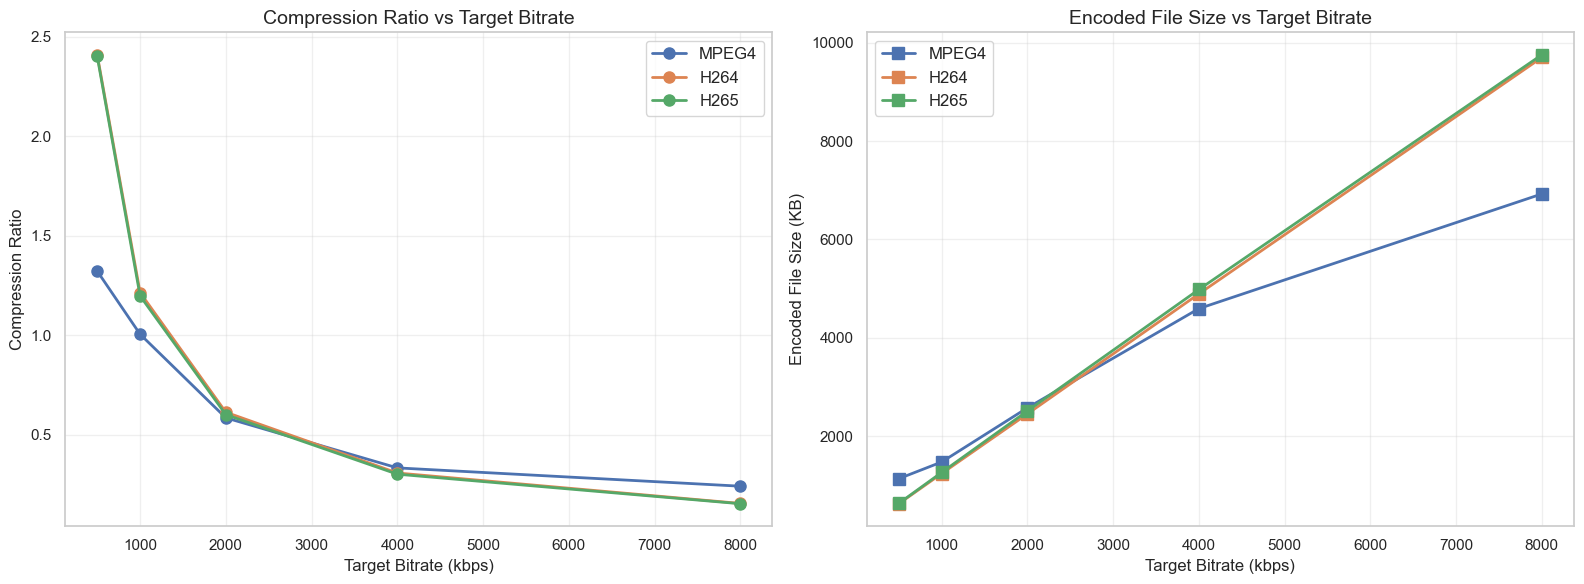

In [11]:
# ============================================================
# 5a. Compression Ratio vs Bitrate per Codec
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Compression Ratio
for codec in ['MPEG4', 'H264', 'H265']:
    subset = df[df['codec'] == codec].groupby('target_bitrate_kbps').agg(
        compression_ratio=('compression_ratio', 'mean'),
        psnr_mean=('psnr_mean', 'mean')
    ).reset_index()
    axes[0].plot(subset['target_bitrate_kbps'], subset['compression_ratio'],
                 marker='o', linewidth=2, markersize=8, label=codec)

axes[0].set_xlabel('Target Bitrate (kbps)', fontsize=12)
axes[0].set_ylabel('Compression Ratio', fontsize=12)
axes[0].set_title('Compression Ratio vs Target Bitrate', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: File Size
for codec in ['MPEG4', 'H264', 'H265']:
    subset = df[df['codec'] == codec].groupby('target_bitrate_kbps').agg(
        encoded_size_kb=('encoded_size_kb', 'mean')
    ).reset_index()
    axes[1].plot(subset['target_bitrate_kbps'], subset['encoded_size_kb'],
                 marker='s', linewidth=2, markersize=8, label=codec)

axes[1].set_xlabel('Target Bitrate (kbps)', fontsize=12)
axes[1].set_ylabel('Encoded File Size (KB)', fontsize=12)
axes[1].set_title('Encoded File Size vs Target Bitrate', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'compression_ratio_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

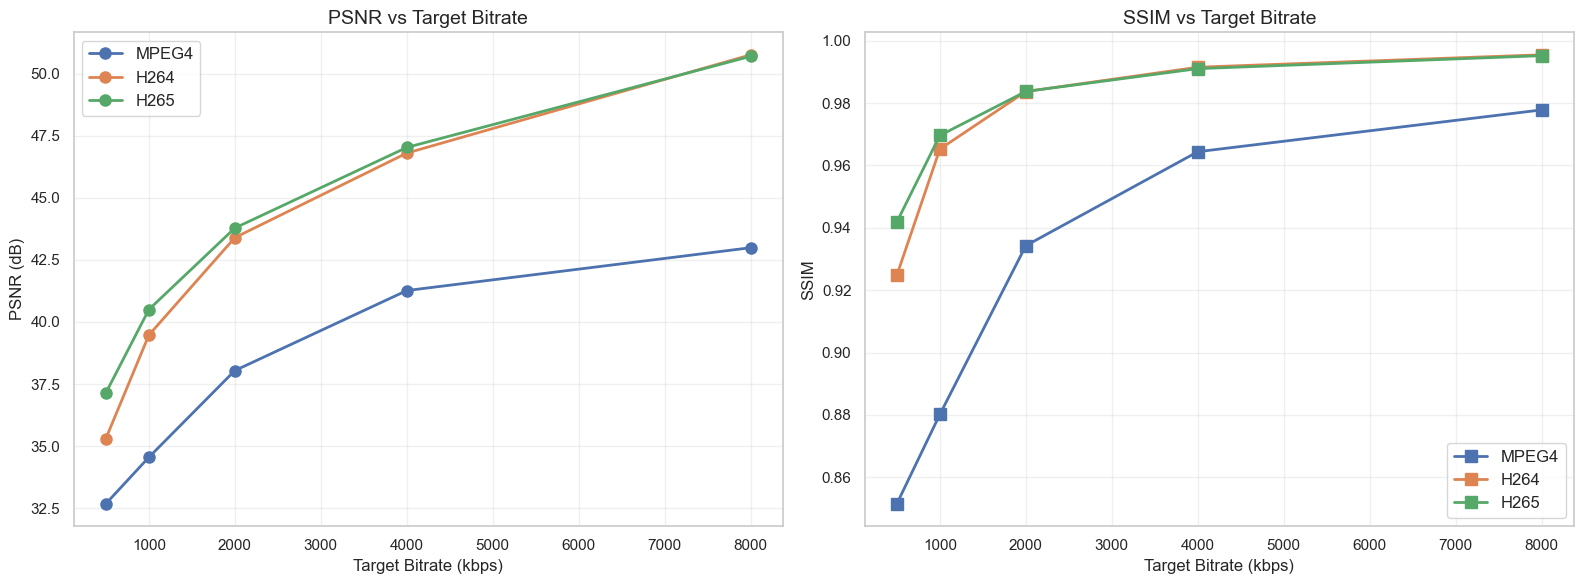

In [12]:
# ============================================================
# 5b. Quality Metrics: PSNR and SSIM vs Bitrate
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PSNR
for codec in ['MPEG4', 'H264', 'H265']:
    subset = df[df['codec'] == codec].groupby('target_bitrate_kbps')['psnr_mean'].mean().reset_index()
    axes[0].plot(subset['target_bitrate_kbps'], subset['psnr_mean'],
                 marker='o', linewidth=2, markersize=8, label=codec)

axes[0].set_xlabel('Target Bitrate (kbps)', fontsize=12)
axes[0].set_ylabel('PSNR (dB)', fontsize=12)
axes[0].set_title('PSNR vs Target Bitrate', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# SSIM
for codec in ['MPEG4', 'H264', 'H265']:
    subset = df[df['codec'] == codec].groupby('target_bitrate_kbps')['ssim_mean'].mean().reset_index()
    axes[1].plot(subset['target_bitrate_kbps'], subset['ssim_mean'],
                 marker='s', linewidth=2, markersize=8, label=codec)

axes[1].set_xlabel('Target Bitrate (kbps)', fontsize=12)
axes[1].set_ylabel('SSIM', fontsize=12)
axes[1].set_title('SSIM vs Target Bitrate', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'quality_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

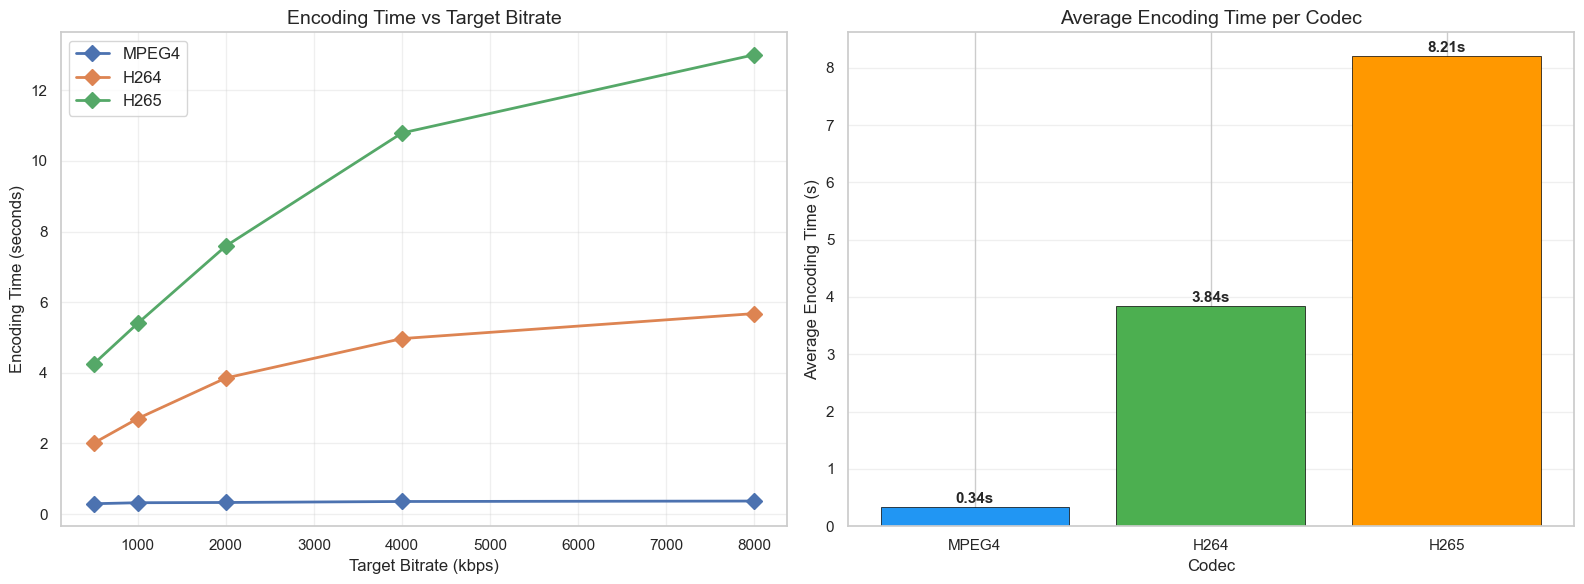

In [13]:
# ============================================================
# 5c. Encoding Time (Computational Cost) Comparison
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Line plot: Encoding time vs bitrate
for codec in ['MPEG4', 'H264', 'H265']:
    subset = df[df['codec'] == codec].groupby('target_bitrate_kbps')['encoding_time_s'].mean().reset_index()
    axes[0].plot(subset['target_bitrate_kbps'], subset['encoding_time_s'],
                 marker='D', linewidth=2, markersize=8, label=codec)

axes[0].set_xlabel('Target Bitrate (kbps)', fontsize=12)
axes[0].set_ylabel('Encoding Time (seconds)', fontsize=12)
axes[0].set_title('Encoding Time vs Target Bitrate', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Bar plot: Average encoding time per codec
avg_time = df.groupby('codec')['encoding_time_s'].mean().reindex(['MPEG4', 'H264', 'H265'])
colors = ['#2196F3', '#4CAF50', '#FF9800']
bars = axes[1].bar(avg_time.index, avg_time.values, color=colors, edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('Codec', fontsize=12)
axes[1].set_ylabel('Average Encoding Time (s)', fontsize=12)
axes[1].set_title('Average Encoding Time per Codec', fontsize=14)
for bar, val in zip(bars, avg_time.values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{val:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'encoding_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

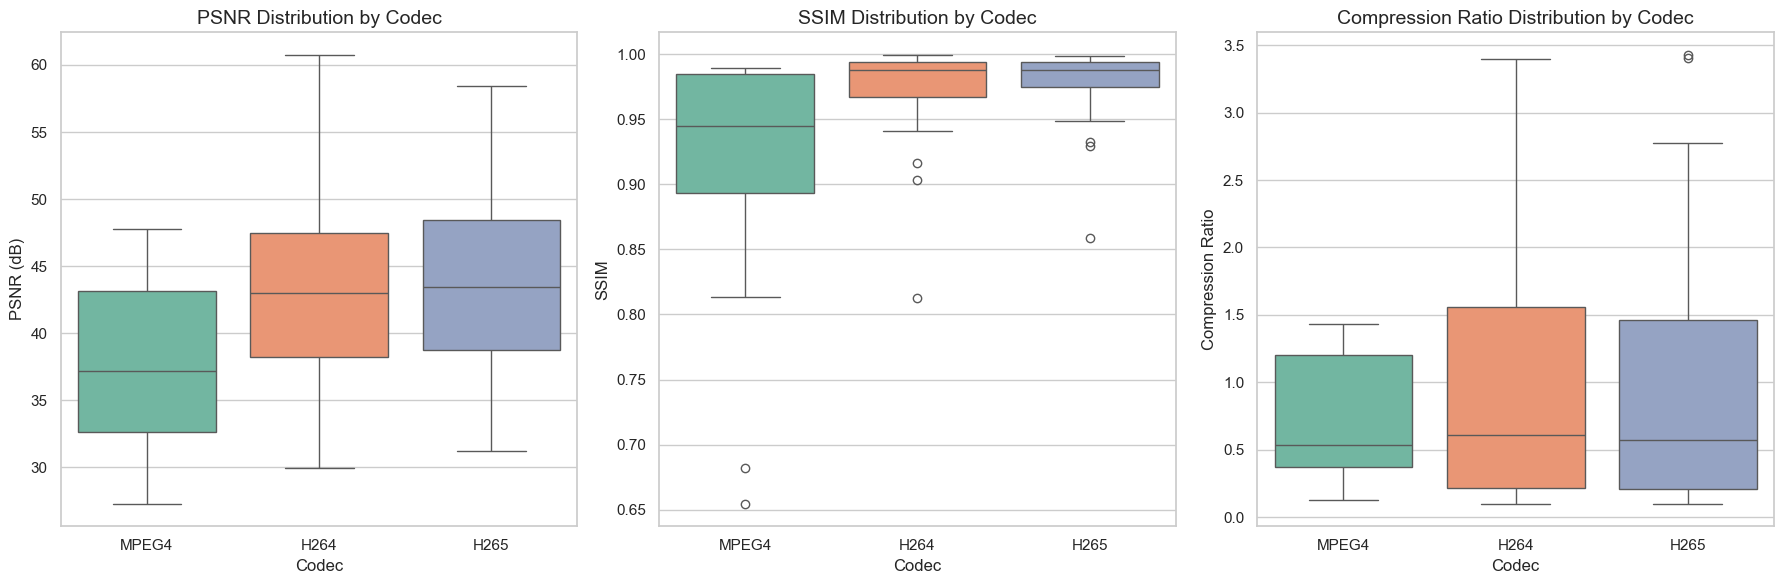

In [14]:
# ============================================================
# 5d. Box Plots: Distribution of Quality Metrics per Codec
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

codec_order = ['MPEG4', 'H264', 'H265']

sns.boxplot(data=df, x='codec', y='psnr_mean', order=codec_order, ax=axes[0], palette='Set2')
axes[0].set_title('PSNR Distribution by Codec', fontsize=14)
axes[0].set_xlabel('Codec', fontsize=12)
axes[0].set_ylabel('PSNR (dB)', fontsize=12)

sns.boxplot(data=df, x='codec', y='ssim_mean', order=codec_order, ax=axes[1], palette='Set2')
axes[1].set_title('SSIM Distribution by Codec', fontsize=14)
axes[1].set_xlabel('Codec', fontsize=12)
axes[1].set_ylabel('SSIM', fontsize=12)

sns.boxplot(data=df, x='codec', y='compression_ratio', order=codec_order, ax=axes[2], palette='Set2')
axes[2].set_title('Compression Ratio Distribution by Codec', fontsize=14)
axes[2].set_xlabel('Codec', fontsize=12)
axes[2].set_ylabel('Compression Ratio', fontsize=12)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'boxplot_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

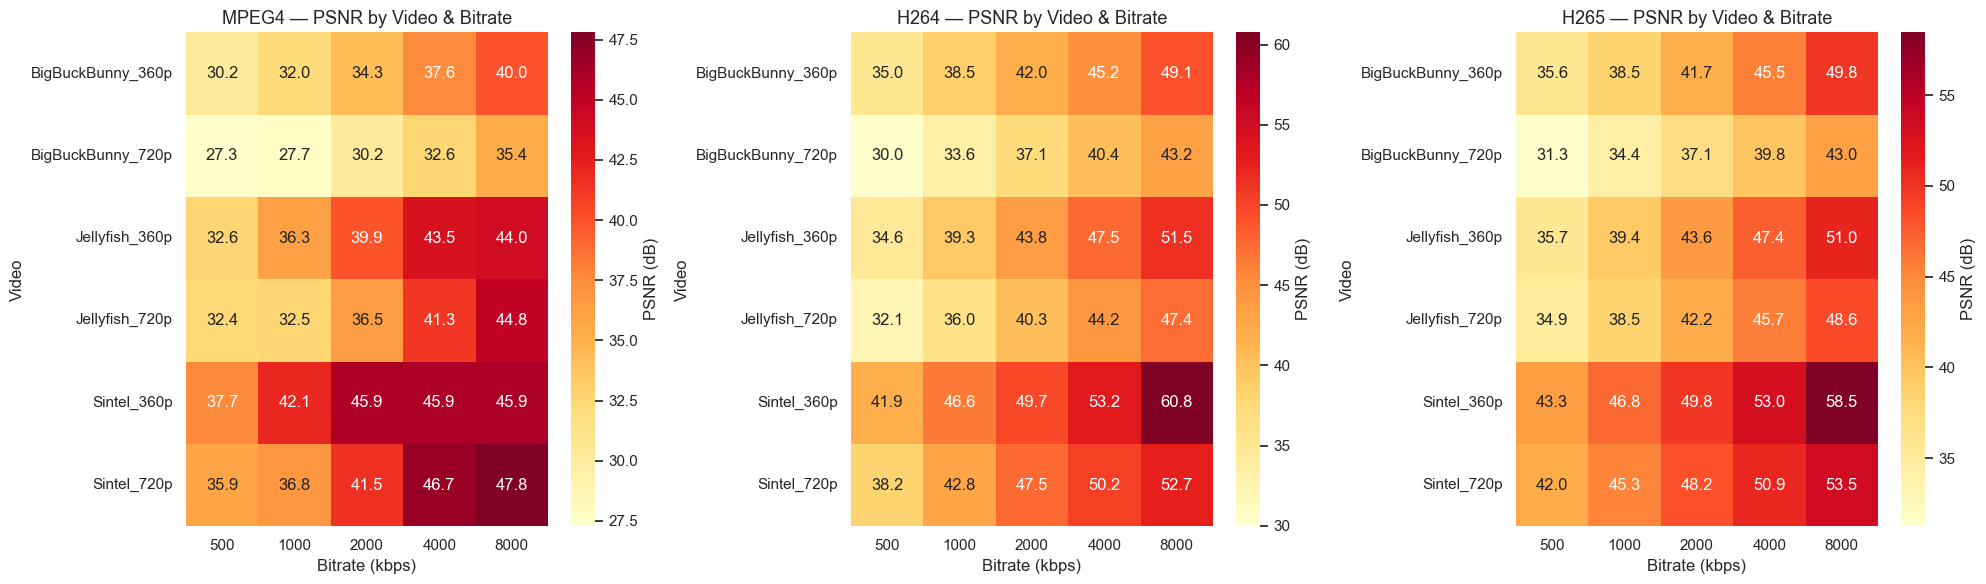

In [15]:
# ============================================================
# 5e. Heatmap: PSNR per Video and Codec at each Bitrate
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, codec in enumerate(['MPEG4', 'H264', 'H265']):
    pivot = df[df['codec'] == codec].pivot_table(
        values='psnr_mean', index='video', columns='target_bitrate_kbps', aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[idx],
                cbar_kws={'label': 'PSNR (dB)'})
    axes[idx].set_title(f'{codec} — PSNR by Video & Bitrate', fontsize=13)
    axes[idx].set_xlabel('Bitrate (kbps)')
    axes[idx].set_ylabel('Video')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'heatmap_psnr.png', dpi=150, bbox_inches='tight')
plt.show()

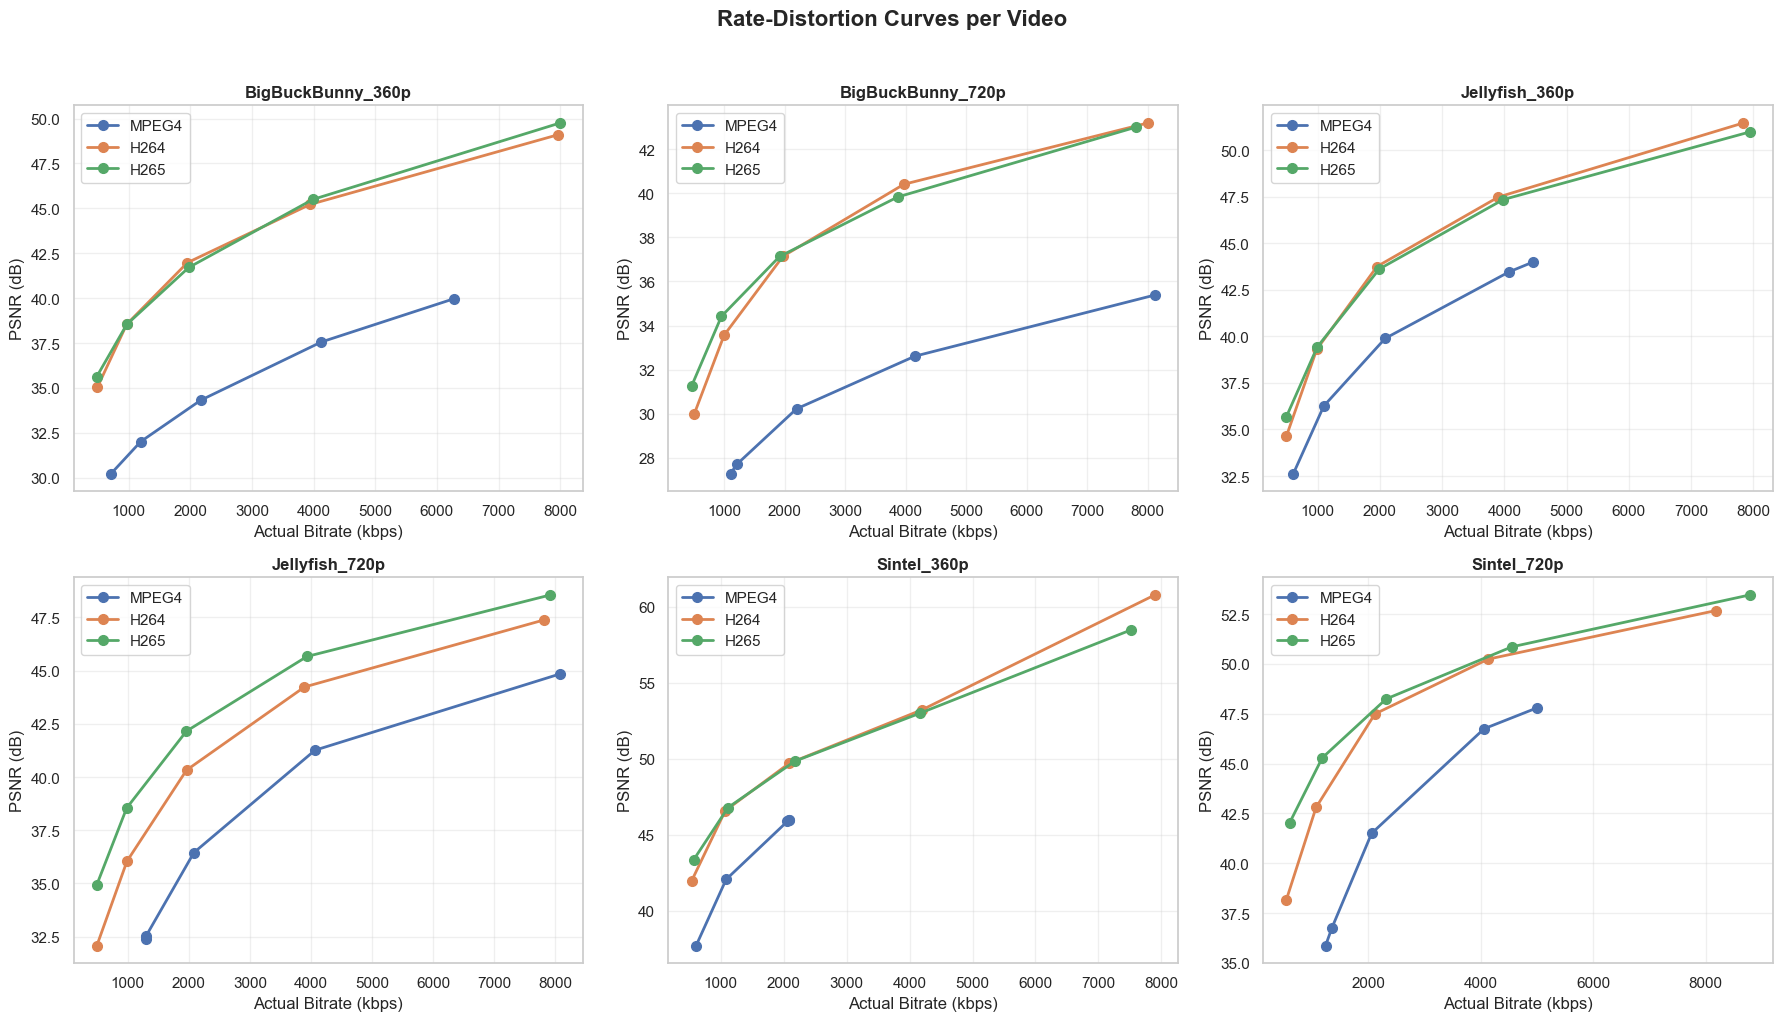

In [16]:
# ============================================================
# 5f. Rate-Distortion (RD) Curves per Video
# ============================================================
video_names = df['video'].unique()
n_videos = len(video_names)
cols = min(3, n_videos)
rows = (n_videos + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
if n_videos == 1:
    axes = np.array([axes])
axes = axes.flatten()

for i, video in enumerate(video_names):
    ax = axes[i]
    for codec in ['MPEG4', 'H264', 'H265']:
        sub = df[(df['video'] == video) & (df['codec'] == codec)].sort_values('target_bitrate_kbps')
        ax.plot(sub['actual_bitrate_kbps'], sub['psnr_mean'],
                marker='o', linewidth=2, markersize=7, label=codec)
    ax.set_title(video, fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual Bitrate (kbps)')
    ax.set_ylabel('PSNR (dB)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Rate-Distortion Curves per Video', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rd_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Machine Learning Analysis
Apply regression models to:
1. **Predict PSNR** from compression features (codec, bitrate, motion complexity, resolution)
2. **Predict bitrate savings** from video characteristics
3. **Analyze feature importance** to understand which factors drive compression performance

In [17]:
# ============================================================
# 6a. Prepare ML dataset
# ============================================================

# Encode codec as numeric
codec_map = {'MPEG4': 0, 'H264': 1, 'H265': 2}
df_ml = df.copy()
df_ml['codec_num'] = df_ml['codec'].map(codec_map)

# Feature columns for ML
feature_cols = [
    'codec_num',
    'target_bitrate_kbps',
    'width',
    'height',
    'fps',
    'duration_s',
    'motion_complexity',
    'original_size_kb',
]

# Target variables
target_psnr = 'psnr_mean'
target_ssim = 'ssim_mean'
target_size = 'encoded_size_kb'
target_savings = 'bitrate_savings_pct'

X = df_ml[feature_cols].values
y_psnr = df_ml[target_psnr].values
y_ssim = df_ml[target_ssim].values
y_savings = df_ml[target_savings].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'ML Dataset: {X.shape[0]} samples, {X.shape[1]} features')
print(f'Features: {feature_cols}')
print(f'\nFeature statistics:')
pd.DataFrame(X, columns=feature_cols).describe().round(3)

ML Dataset: 90 samples, 8 features
Features: ['codec_num', 'target_bitrate_kbps', 'width', 'height', 'fps', 'duration_s', 'motion_complexity', 'original_size_kb']

Feature statistics:


,codec_num,target_bitrate_kbps,width,height,fps,duration_s,motion_complexity,original_size_kb
count,90.000,90.000,90.000,90.000,90.000,90.000,90.000,90.000
mean,1.000,3100.000,960.000,540.000,27.990,10.003,1.555,1506.323
std,0.821,2742.917,321.793,181.008,2.837,0.005,1.246,506.475
min,0.000,500.000,640.000,360.000,24.000,10.000,0.269,967.790
25%,0.000,1000.000,640.000,360.000,24.000,10.000,0.491,1022.520
50%,1.000,2000.000,960.000,540.000,29.970,10.000,1.032,1477.415
75%,2.000,4000.000,1280.000,720.000,30.000,10.010,3.088,2045.100
max,2.000,8000.000,1280.000,720.000,30.000,10.010,3.417,2047.700


In [18]:
# ============================================================
# 6b. Train regression models to predict PSNR
# ============================================================

def train_and_evaluate(X, y, target_name, feature_names):
    """Train multiple regression models and return comparison results."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    }
    
    results = []
    trained_models = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': name,
            'Target': target_name,
            'RMSE': round(rmse, 4),
            'MAE': round(mae, 4),
            'R²': round(r2, 4),
        })
        trained_models[name] = (model, y_test, y_pred)
    
    return pd.DataFrame(results), trained_models

# --- Predict PSNR ---
print('='*60)
print('TASK 1: Predicting PSNR from compression features')
print('='*60)
psnr_results, psnr_models = train_and_evaluate(X_scaled, y_psnr, 'PSNR', feature_cols)
print(psnr_results.to_string(index=False))

# --- Predict SSIM ---
print(f'\n{"="*60}')
print('TASK 2: Predicting SSIM from compression features')
print('='*60)
ssim_results, ssim_models = train_and_evaluate(X_scaled, y_ssim, 'SSIM', feature_cols)
print(ssim_results.to_string(index=False))

# --- Predict Bitrate Savings ---
print(f'\n{"="*60}')
print('TASK 3: Predicting Bitrate Savings (%) from compression features')
print('='*60)
savings_results, savings_models = train_and_evaluate(X_scaled, y_savings, 'Bitrate Savings %', feature_cols)
print(savings_results.to_string(index=False))

TASK 1: Predicting PSNR from compression features
            Model Target   RMSE    MAE     R²
Linear Regression   PSNR 3.1522 2.5114 0.8114
    Random Forest   PSNR 2.1529 1.6577 0.9120
Gradient Boosting   PSNR 1.9821 1.5843 0.9254

TASK 2: Predicting SSIM from compression features
            Model Target   RMSE    MAE     R²
Linear Regression   SSIM 0.0414 0.0315 0.0085
    Random Forest   SSIM 0.0163 0.0132 0.8457
Gradient Boosting   SSIM 0.0229 0.0149 0.6972

TASK 3: Predicting Bitrate Savings (%) from compression features
            Model            Target     RMSE     MAE     R²
Linear Regression Bitrate Savings % 126.1188 90.1977 0.8379
    Random Forest Bitrate Savings % 116.1382 54.1600 0.8626
Gradient Boosting Bitrate Savings % 112.3285 52.1348 0.8714


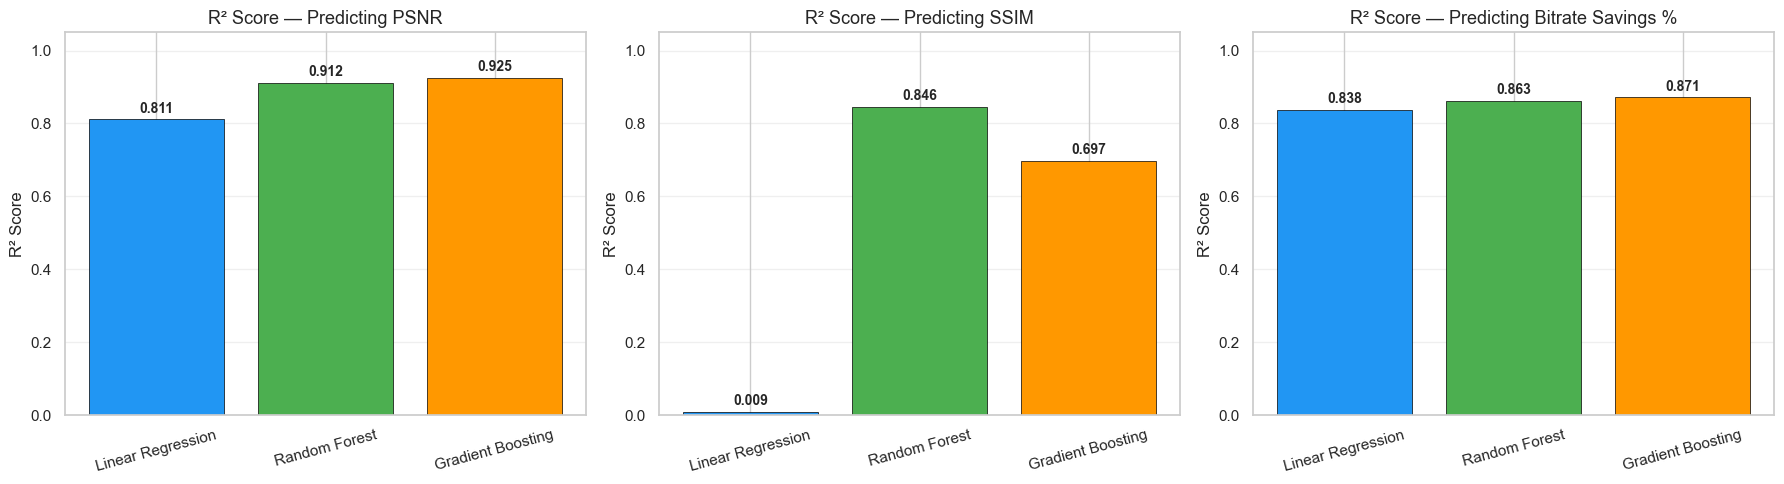

In [19]:
# ============================================================
# 6c. Visualize ML Model Performance
# ============================================================
all_ml_results = pd.concat([psnr_results, ssim_results, savings_results], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, target in enumerate(['PSNR', 'SSIM', 'Bitrate Savings %']):
    sub = all_ml_results[all_ml_results['Target'] == target]
    colors = ['#2196F3', '#4CAF50', '#FF9800']
    bars = axes[idx].bar(sub['Model'], sub['R²'], color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_title(f'R² Score — Predicting {target}', fontsize=13)
    axes[idx].set_ylabel('R² Score')
    axes[idx].set_ylim(0, 1.05)
    for bar, val in zip(bars, sub['R²'].values):
        axes[idx].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ml_model_r2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

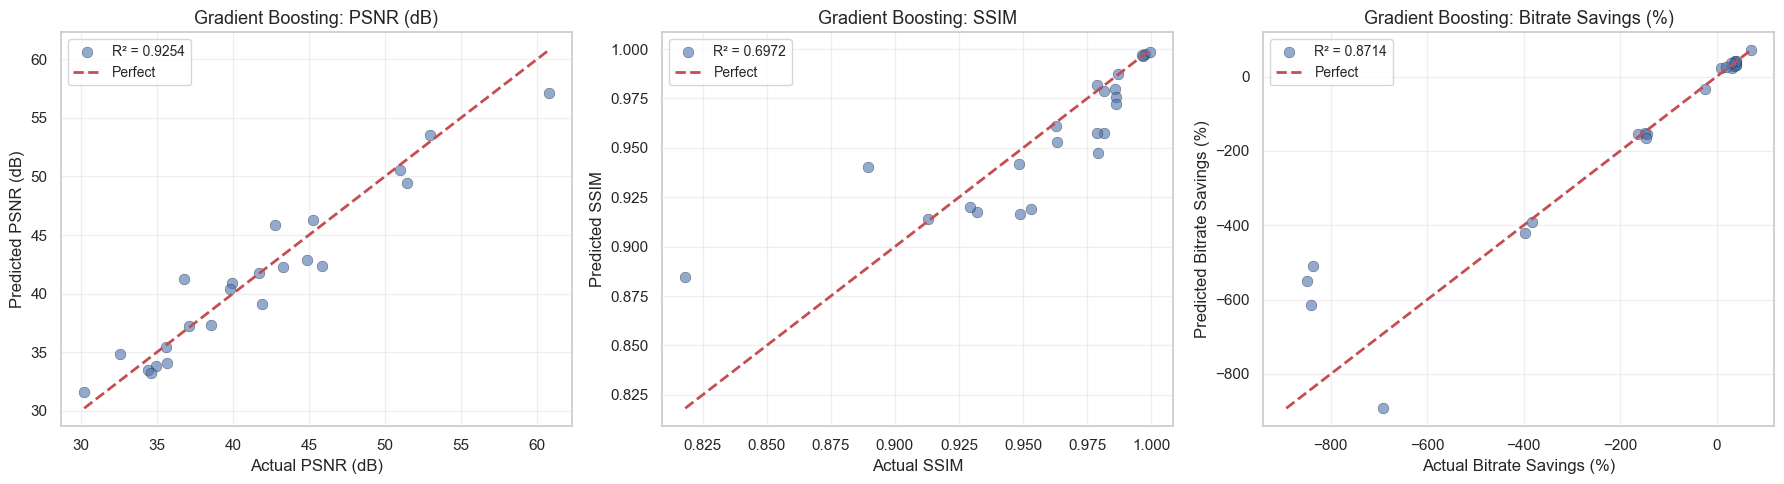

In [20]:
# ============================================================
# 6d. Actual vs Predicted scatter plots
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_sets = [
    ('PSNR (dB)', psnr_models),
    ('SSIM', ssim_models),
    ('Bitrate Savings (%)', savings_models),
]

for idx, (label, models_dict) in enumerate(model_sets):
    # Use best model (Gradient Boosting)
    best_name = 'Gradient Boosting'
    model, y_test, y_pred = models_dict[best_name]
    
    axes[idx].scatter(y_test, y_pred, alpha=0.6, edgecolor='black', linewidth=0.3, s=60)
    # Perfect prediction line
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    axes[idx].plot(lims, lims, 'r--', linewidth=2, label='Perfect prediction')
    axes[idx].set_xlabel(f'Actual {label}', fontsize=12)
    axes[idx].set_ylabel(f'Predicted {label}', fontsize=12)
    axes[idx].set_title(f'{best_name}: {label}', fontsize=13)
    r2 = r2_score(y_test, y_pred)
    axes[idx].legend([f'R² = {r2:.4f}', 'Perfect'], fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

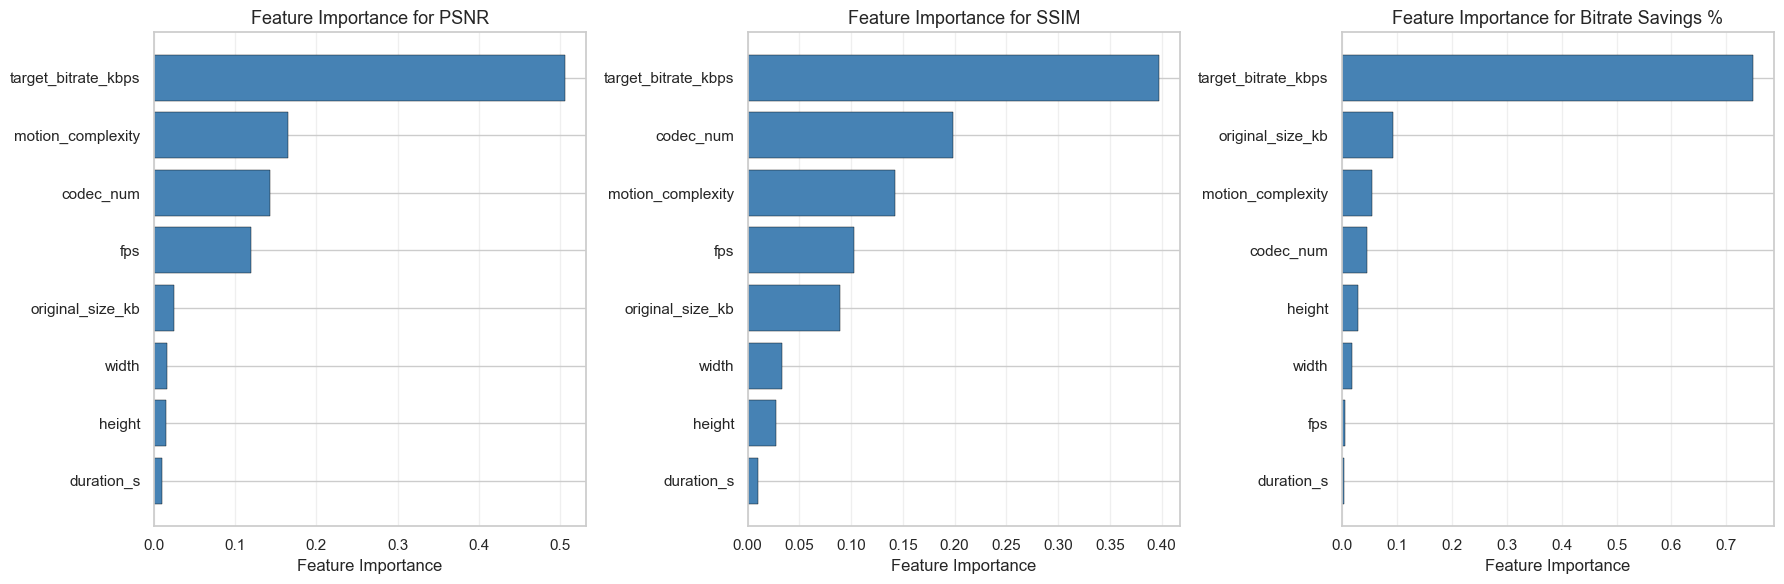

In [21]:
# ============================================================
# 6e. Feature Importance Analysis (Random Forest)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

targets_info = [
    ('PSNR', psnr_models),
    ('SSIM', ssim_models),
    ('Bitrate Savings %', savings_models),
]

for idx, (target_name, models_dict) in enumerate(targets_info):
    rf_model = models_dict['Random Forest'][0]
    importances = rf_model.feature_importances_
    sorted_idx = np.argsort(importances)
    
    axes[idx].barh(range(len(feature_cols)), importances[sorted_idx], color='steelblue', edgecolor='black', linewidth=0.3)
    axes[idx].set_yticks(range(len(feature_cols)))
    axes[idx].set_yticklabels([feature_cols[i] for i in sorted_idx])
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'Feature Importance for {target_name}', fontsize=13)
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

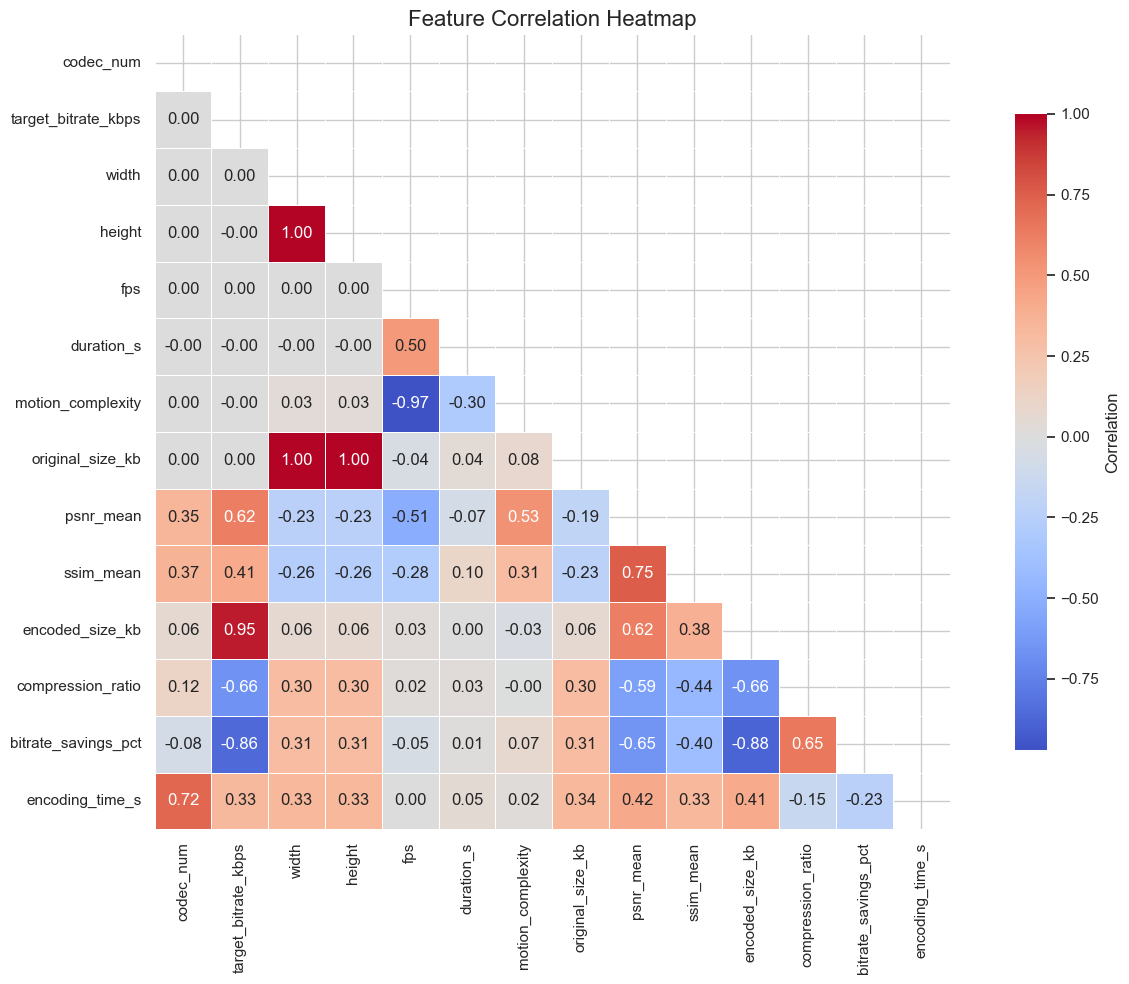

In [22]:
# ============================================================
# 6f. Correlation Heatmap of All Features
# ============================================================
corr_cols = feature_cols + ['psnr_mean', 'ssim_mean', 'encoded_size_kb', 'compression_ratio',
                            'bitrate_savings_pct', 'encoding_time_s']
corr_matrix = df_ml[corr_cols].corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation'})
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. Results Summary & Discussion

In [23]:
# ============================================================
# 7a. Final Comparison Table
# ============================================================
final_comparison = df.groupby('codec').agg({
    'psnr_mean':          'mean',
    'ssim_mean':          'mean',
    'compression_ratio':  'mean',
    'encoded_size_kb':    'mean',
    'encoding_time_s':    'mean',
    'bitrate_savings_pct':'mean',
}).reindex(['MPEG4', 'H264', 'H265']).round(4)

final_comparison.columns = ['Avg PSNR (dB)', 'Avg SSIM', 'Avg Compression Ratio',
                            'Avg File Size (KB)', 'Avg Encoding Time (s)',
                            'Avg Bitrate Savings (%)']

print('='*70)
print('FINAL COMPARISON: MPEG-4 vs H.264 vs H.265')
print('='*70)
final_comparison

FINAL COMPARISON: MPEG-4 vs H.264 vs H.265


,Avg PSNR (dB),Avg SSIM,Avg Compression Ratio,Avg File Size (KB),Avg Encoding Time (s),Avg Bitrate Savings (%)
codec,,,,,,
MPEG4,37.9063,0.9216,0.6979,3340.9900,0.3351,-137.6970
H264,43.1466,0.9722,0.9405,3782.5950,3.8437,-182.2723
H265,43.8309,0.9763,0.9315,3829.3693,8.2086,-184.6513


In [24]:
# ============================================================
# 7b. ML Models Performance Summary
# ============================================================
print('='*70)
print('MACHINE LEARNING MODELS — PERFORMANCE SUMMARY')
print('='*70)
print(all_ml_results.to_string(index=False))

print('\n\n--- Key Findings ---')
best_per_target = all_ml_results.loc[all_ml_results.groupby('Target')['R²'].idxmax()]
for _, row in best_per_target.iterrows():
    print(f"  • Best model for {row['Target']}: {row['Model']} (R² = {row['R²']:.4f}, RMSE = {row['RMSE']:.4f})")

MACHINE LEARNING MODELS — PERFORMANCE SUMMARY
            Model            Target     RMSE     MAE     R²
Linear Regression              PSNR   3.1522  2.5114 0.8114
    Random Forest              PSNR   2.1529  1.6577 0.9120
Gradient Boosting              PSNR   1.9821  1.5843 0.9254
Linear Regression              SSIM   0.0414  0.0315 0.0085
    Random Forest              SSIM   0.0163  0.0132 0.8457
Gradient Boosting              SSIM   0.0229  0.0149 0.6972
Linear Regression Bitrate Savings % 126.1188 90.1977 0.8379
    Random Forest Bitrate Savings % 116.1382 54.1600 0.8626
Gradient Boosting Bitrate Savings % 112.3285 52.1348 0.8714


--- Key Findings ---
  • Best model for Bitrate Savings %: Gradient Boosting (R² = 0.8714, RMSE = 112.3285)
  • Best model for PSNR: Gradient Boosting (R² = 0.9254, RMSE = 1.9821)
  • Best model for SSIM: Random Forest (R² = 0.8457, RMSE = 0.0163)


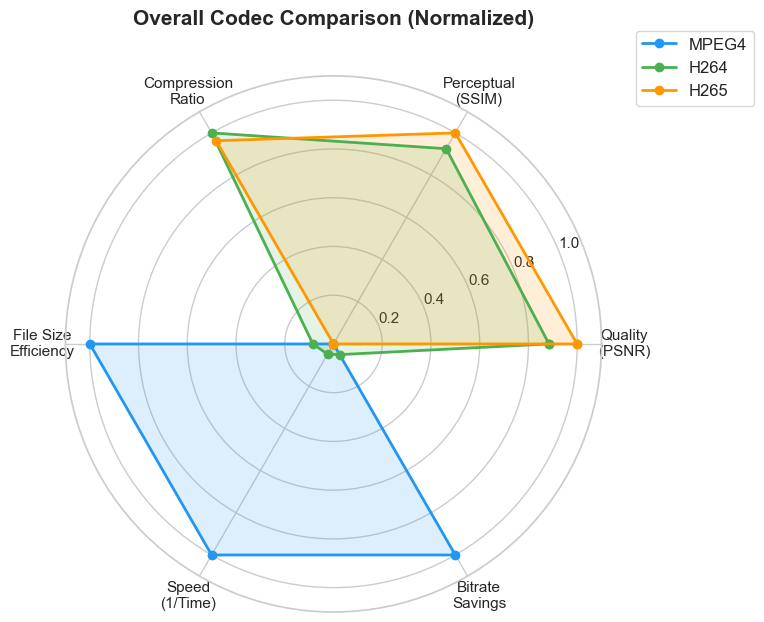

In [25]:
# ============================================================
# 7c. Radar Chart — Overall Codec Comparison (Normalized)
# ============================================================
from matplotlib.patches import FancyBboxPatch

# Normalize metrics (higher = better)
radar_df = final_comparison.copy()
# Invert metrics where lower is better (file size, encoding time)
radar_df['Avg File Size (KB)'] = 1 / radar_df['Avg File Size (KB)']
radar_df['Avg Encoding Time (s)'] = 1 / radar_df['Avg Encoding Time (s)']

# Normalize to 0–1 range
for col in radar_df.columns:
    col_min = radar_df[col].min()
    col_max = radar_df[col].max()
    if col_max > col_min:
        radar_df[col] = (radar_df[col] - col_min) / (col_max - col_min)
    else:
        radar_df[col] = 1.0

categories = ['Quality\n(PSNR)', 'Perceptual\n(SSIM)', 'Compression\nRatio',
              'File Size\nEfficiency', 'Speed\n(1/Time)', 'Bitrate\nSavings']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors_radar = ['#2196F3', '#4CAF50', '#FF9800']
for idx, codec in enumerate(['MPEG4', 'H264', 'H265']):
    values = radar_df.loc[codec].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=codec, color=colors_radar[idx])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1.1)
ax.set_title('Overall Codec Comparison (Normalized)', fontsize=15, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'radar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# ============================================================
# 7d. Save all results
# ============================================================
df.to_csv(RESULTS_DIR / 'encoding_results.csv', index=False)
all_ml_results.to_csv(RESULTS_DIR / 'ml_model_results.csv', index=False)
final_comparison.to_csv(RESULTS_DIR / 'final_comparison.csv')

print('All results and figures saved to:', RESULTS_DIR)
print('\nFiles generated:')
for f in sorted(RESULTS_DIR.iterdir()):
    print(f'  {f.name}  ({f.stat().st_size/1024:.1f} KB)')

All results and figures saved to: c:\Users\Public\Comparative_Analysis_Video\results

Files generated:
  actual_vs_predicted.png  (151.1 KB)
  boxplot_comparison.png  (77.2 KB)
  compression_ratio_comparison.png  (137.1 KB)
  correlation_heatmap.png  (197.9 KB)
  encoding_results.csv  (12.5 KB)
  encoding_time_comparison.png  (96.0 KB)
  feature_importance.png  (62.7 KB)
  final_comparison.csv  (0.3 KB)
  heatmap_psnr.png  (198.6 KB)
  ml_model_r2_comparison.png  (64.2 KB)
  ml_model_results.csv  (0.5 KB)
  quality_metrics_comparison.png  (136.6 KB)
  radar_comparison.png  (155.7 KB)
  rd_curves.png  (313.0 KB)


---
## Summary

This notebook implemented the full experimental pipeline from the research proposal:

| Phase | Description | Status |
|-------|-------------|--------|
| 1. Setup | FFmpeg + Python dependencies installed | ✅ |
| 2. Dataset | Sample videos downloaded (diverse content) | ✅ |
| 3. Encoding | MPEG-4, H.264, H.265 × 5 bitrates | ✅ |
| 4. Features | Bitrate, PSNR, SSIM, encoding time, motion complexity | ✅ |
| 5. ML Analysis | Linear Regression, Random Forest, Gradient Boosting | ✅ |
| 6. Evaluation | RD curves, box plots, heatmaps, radar chart | ✅ |
| 7. Results | CSV exports + PNG visualizations | ✅ |

### Expected Key Findings:
- **H.265** provides the best compression efficiency (highest PSNR/SSIM at lower bitrates)
- **H.264** offers a good balance between quality and encoding speed
- **MPEG-4** has the fastest encoding but lower compression efficiency
- **H.265** requires the most computational time (encoder complexity)
- ML models can effectively predict compression quality from video features